In [ ]:
# MYSQL DB 생성
import pymysql

conn = pymysql.connect(host='localhost',
user = 'root', password='0220vnfma!!', charset = 'utf8mb4')

with conn:
    with conn.cursor() as cur:
        cur.execute('CREATE DATABASE KB_PT')
        conn.commit()

In [94]:
# MYSQL Data 불러오기 (TOSS_VOC Table)
import pymysql

tdb = pymysql.connect(host='localhost',
user = 'root', password='0220vnfma!!', db = 'KB_PT',charset = 'utf8mb4')

cursor = tdb.cursor()

sql1 = "SELECT * FROM 01_DATA1"
sql2 = "SELECT * FROM 01_DATA2"
sql3 = "SELECT * FROM 01_DATA3"
sql4 = "SELECT * FROM 01_DATA4"
sql_list = [sql1, sql2, sql3, sql4]
result = []

for i in range(4):
    cursor.execute(sql_list[i])
    tmp = cursor.fetchall()
    result.append(tmp)

tdb.commit()
tdb.close()

In [243]:
# 필요한 라이브러리 임포트

import pandas as pd
import json
import numpy as np
import folium
from folium.features import DivIcon
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from datetime import datetime
import seaborn as sns
import scipy.stats as stats
import math

In [197]:
# data 입력하기

df = [[] for _ in range(4)]

for i in range(4):
    df[i] = pd.DataFrame(result[i])

df

[          0         1    2      3  4
 0      0001  20200102  137  44.37  5
 1      0001  20200103  144  41.94  5
 2      0001  20200106  144  27.96  4
 3      0001  20200107  119  33.80  4
 4      0001  20200108  130  21.28  4
 ...     ...       ...  ...    ... ..
 18535  0060  20210325  222  12.47  4
 18536  0060  20210326  168  16.13  4
 18537  0060  20210329  185  15.34  4
 18538  0060  20210330  199  14.23  4
 18539  0060  20210331  172  14.98  4
 
 [18540 rows x 5 columns],
         0       1     2         3         4         5         6
 0    0001  202001  2835  0.089744  0.213675  0.430403  0.266178
 1    0001  202002  2720  0.106796  0.252427  0.424900  0.215877
 2    0001  202003  3273  0.104530  0.213041  0.442509  0.239920
 3    0001  202004  3062  0.086377  0.229565  0.433623  0.250435
 4    0001  202005  3071  0.083447  0.208618  0.432285  0.275650
 ..    ...     ...   ...       ...       ...       ...       ...
 895  0060  202011  3157  0.093506  0.292468  0.442078  0.17

In [198]:
df[2] = df[2].drop(0, axis=0)

In [199]:
df[0].columns = ['센터코드', '년월일', '방문고객수', '평균대기시간', '고객집중도']
df[1].columns = ['센터코드', '년월', '방문고객수', '고객비율_20대미만', '고객비율_20대30대', '고객비율_40대50대', '고객비율_60대이상'
]
df[2].columns = ['센터코드', '센터유형', '시도', '시군구', '행정동']
df[3].columns = ['년월일', '휴일여부']

In [200]:
# 휴무일에 영업하는 센터가 있는지 확인하는 코드 -> 없다. -> data4 는 사용할 이유가 없는 것으로 추정된다.

list1 = list(df[0]['년월일'])
list2 = list(df[3]['년월일'])
list3 = list(df[3]['휴일여부'])
holidays = []

for i,j in zip(list2,list3):
    if j == 'Y':
        holidays.append(i)

for i in holidays:
    if i in list1:
        print("휴무에도 일함")
        print(i)
else:
    print("휴무는 쉼")

휴무는 쉼


In [201]:
# data1,2,3 모두 합치기 시작

df[0] = df[0].astype({'년월일':'str'})
df[0]['년월일']=df[0]['년월일'].apply(lambda _ : datetime.strptime(_,'%Y%m%d'))

In [202]:
df[0]['month'] = df[0]['년월일'].dt.month
df[0]['year'] = df[0]['년월일'].dt.year
df[0] = df[0].astype({'month':'str'})
df[0] = df[0].astype({'year':'str'})

In [203]:
df[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18540 entries, 0 to 18539
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   센터코드    18540 non-null  object        
 1   년월일     18540 non-null  datetime64[ns]
 2   방문고객수   18540 non-null  int64         
 3   평균대기시간  18540 non-null  float64       
 4   고객집중도   18540 non-null  int64         
 5   month   18540 non-null  object        
 6   year    18540 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 1014.0+ KB


In [204]:
df[0]["년월"] = df[0]["year"] + "-" + df[0]["month"]
df[0]['년월'] = pd.to_datetime(df[0]['년월'], format='%Y/%m')

In [205]:
df[0]

센터코드        년월일  방문고객수  평균대기시간  고객집중도 month  year         년월
0      0001 2020-01-02    137   44.37      5     1  2020 2020-01-01
1      0001 2020-01-03    144   41.94      5     1  2020 2020-01-01
2      0001 2020-01-06    144   27.96      4     1  2020 2020-01-01
3      0001 2020-01-07    119   33.80      4     1  2020 2020-01-01
4      0001 2020-01-08    130   21.28      4     1  2020 2020-01-01
...     ...        ...    ...     ...    ...   ...   ...        ...
18535  0060 2021-03-25    222   12.47      4     3  2021 2021-03-01
18536  0060 2021-03-26    168   16.13      4     3  2021 2021-03-01
18537  0060 2021-03-29    185   15.34      4     3  2021 2021-03-01
18538  0060 2021-03-30    199   14.23      4     3  2021 2021-03-01
18539  0060 2021-03-31    172   14.98      4     3  2021 2021-03-01

[18540 rows x 8 columns]

In [325]:
rev1 = df[0].groupby(by='년월').mean()
rev1.insert(0,'년월',sorted(list(set(df[0]['년월'].tolist()))))

#rev1

rev2 = df[0].groupby(by=['센터코드', '년월']).mean()
rev2.columns = ['방문고객수', '평균대기시간', '고객집중도']
rev1

년월       방문고객수     평균대기시간     고객집중도
년월                                                    
2020-01-01 2020-01-01  183.876667  23.984158  4.113333
2020-02-01 2020-02-01  164.000833  22.911067  4.010833
2020-03-01 2020-03-01  164.038636  17.079689  3.592424
2020-04-01 2020-04-01  163.675000  15.904708  3.512500
2020-05-01 2020-05-01  175.566667  21.989833  3.929825
2020-06-01 2020-06-01  157.056061  13.596841  3.323485
2020-07-01 2020-07-01  155.221014  14.923862  3.420290
2020-08-01 2020-08-01  154.904167  19.281908  3.815000
2020-09-01 2020-09-01  154.329365  18.604897  3.741270
2020-10-01 2020-10-01  155.946491  17.943982  3.665789
2020-11-01 2020-11-01  144.538095  16.721159  3.568254
2020-12-01 2020-12-01  148.628030  17.562652  3.738636
2021-01-01 2021-01-01  145.115833  14.446225  3.450000
2021-02-01 2021-02-01  157.209259  16.491704  3.638889
2021-03-01 2021-03-01  157.706818  13.795326  3.349242

In [207]:
df[1] = df[1].astype({'년월':'str'})
df[1]['년월']=df[1]['년월'].apply(lambda _ : datetime.strptime(_,'%Y%m'))

In [208]:
df[1]

센터코드         년월  방문고객수  고객비율_20대미만  고객비율_20대30대  고객비율_40대50대  고객비율_60대이상
0    0001 2020-01-01   2835    0.089744     0.213675     0.430403    0.266178
1    0001 2020-02-01   2720    0.106796     0.252427     0.424900    0.215877
2    0001 2020-03-01   3273    0.104530     0.213041     0.442509    0.239920
3    0001 2020-04-01   3062    0.086377     0.229565     0.433623    0.250435
4    0001 2020-05-01   3071    0.083447     0.208618     0.432285    0.275650
..    ...        ...    ...         ...          ...          ...         ...
895  0060 2020-11-01   3157    0.093506     0.292468     0.442078    0.171948
896  0060 2020-12-01   3411    0.096096     0.268769     0.437437    0.197698
897  0060 2021-01-01   2974    0.101567     0.260012     0.454440    0.183981
898  0060 2021-02-01   3012    0.116438     0.265753     0.429452    0.188356
899  0060 2021-03-01   3940    0.113505     0.260641     0.429848    0.196006

[900 rows x 7 columns]

In [209]:
df01 = pd.merge(df[0], rev2, on= ['센터코드', '년월'])
df01 = df01.drop(['month', 'year'], axis=1)
df01

센터코드        년월일  방문고객수  평균대기시간  고객집중도         년월  센터 및 월별 평균 방문고객수  \
0      0001 2020-01-02    137   44.37      5 2020-01-01        141.750000   
1      0001 2020-01-03    144   41.94      5 2020-01-01        141.750000   
2      0001 2020-01-06    144   27.96      4 2020-01-01        141.750000   
3      0001 2020-01-07    119   33.80      4 2020-01-01        141.750000   
4      0001 2020-01-08    130   21.28      4 2020-01-01        141.750000   
...     ...        ...    ...     ...    ...        ...               ...   
18535  0060 2021-03-25    222   12.47      4 2021-03-01        179.090909   
18536  0060 2021-03-26    168   16.13      4 2021-03-01        179.090909   
18537  0060 2021-03-29    185   15.34      4 2021-03-01        179.090909   
18538  0060 2021-03-30    199   14.23      4 2021-03-01        179.090909   
18539  0060 2021-03-31    172   14.98      4 2021-03-01        179.090909   

       센터 및 월별 평균대기시간  센터 및 월별 평균고객집중도  
0           37.955000         4.800000  
1           37.955000         4.800000  
2           37.955000         4.800000  
3           37.955000         4.800000  
4           37.955000         4.800000  
...               ...              ...  
18535       14.716364         3.636364  
18536       14.716364         3.636364  
18537       14.716364         3.636364  
18538       14.716364         3.636364  
18539       14.716364         3.636364  

[18540 rows x 9 columns]

In [210]:
df02 = pd.merge(df01, df[2], on='센터코드')
df02.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18540 entries, 0 to 18539
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   센터코드              18540 non-null  object        
 1   년월일               18540 non-null  datetime64[ns]
 2   방문고객수             18540 non-null  int64         
 3   평균대기시간            18540 non-null  float64       
 4   고객집중도             18540 non-null  int64         
 5   년월                18540 non-null  datetime64[ns]
 6   센터 및 월별 평균 방문고객수  18540 non-null  float64       
 7   센터 및 월별 평균대기시간    18540 non-null  float64       
 8   센터 및 월별 평균고객집중도   18540 non-null  float64       
 9   센터유형              18540 non-null  object        
 10  시도                18540 non-null  object        
 11  시군구               18540 non-null  object        
 12  행정동               18540 non-null  object        
dtypes: datetime64[ns](2), float64(4), int64(2), object(5)
memory usage: 2.0+ MB


In [211]:
df03 = pd.merge(df02, df[1], on=['센터코드','년월'])
df03

센터코드        년월일  방문고객수_x  평균대기시간  고객집중도         년월  센터 및 월별 평균 방문고객수  \
0      0001 2020-01-02      137   44.37      5 2020-01-01        141.750000   
1      0001 2020-01-03      144   41.94      5 2020-01-01        141.750000   
2      0001 2020-01-06      144   27.96      4 2020-01-01        141.750000   
3      0001 2020-01-07      119   33.80      4 2020-01-01        141.750000   
4      0001 2020-01-08      130   21.28      4 2020-01-01        141.750000   
...     ...        ...      ...     ...    ...        ...               ...   
18535  0060 2021-03-25      222   12.47      4 2021-03-01        179.090909   
18536  0060 2021-03-26      168   16.13      4 2021-03-01        179.090909   
18537  0060 2021-03-29      185   15.34      4 2021-03-01        179.090909   
18538  0060 2021-03-30      199   14.23      4 2021-03-01        179.090909   
18539  0060 2021-03-31      172   14.98      4 2021-03-01        179.090909   

       센터 및 월별 평균대기시간  센터 및 월별 평균고객집중도 센터유형  시도  시군구    행정동  방문고객수_y  \
0           37.955000         4.800000    S  서울  마포구    아현동     2835   
1           37.955000         4.800000    S  서울  마포구    아현동     2835   
2           37.955000         4.800000    S  서울  마포구    아현동     2835   
3           37.955000         4.800000    S  서울  마포구    아현동     2835   
4           37.955000         4.800000    S  서울  마포구    아현동     2835   
...               ...              ...  ...  ..  ...    ...      ...   
18535       14.716364         3.636364    S  서울  은평구  응암제1동     3940   
18536       14.716364         3.636364    S  서울  은평구  응암제1동     3940   
18537       14.716364         3.636364    S  서울  은평구  응암제1동     3940   
18538       14.716364         3.636364    S  서울  은평구  응암제1동     3940   
18539       14.716364         3.636364    S  서울  은평구  응암제1동     3940   

       고객비율_20대미만  고객비율_20대30대  고객비율_40대50대  고객비율_60대이상  
0        0.089744     0.213675     0.430403    0.266178  
1        0.089744     0.213675     0.430403    0.266178  
2        0.089744     0.213675     0.430403    0.266178  
3        0.089744     0.213675     0.430403    0.266178  
4        0.089744     0.213675     0.430403    0.266178  
...           ...          ...          ...         ...  
18535    0.113505     0.260641     0.429848    0.196006  
18536    0.113505     0.260641     0.429848    0.196006  
18537    0.113505     0.260641     0.429848    0.196006  
18538    0.113505     0.260641     0.429848    0.196006  
18539    0.113505     0.260641     0.429848    0.196006  

[18540 rows x 18 columns]

방문고객수 & 평균대기시간 상관관계 : 0.6697773480801862
방문고객수 & 평균대기시간 p-value : 0.0063022048909444975


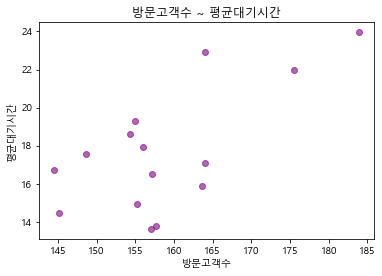

방문고객수 & 고객집중도 상관관계 : 0.5990362908553867
방문고객수 & 고객집중도 p-value : 0.018284868066226305


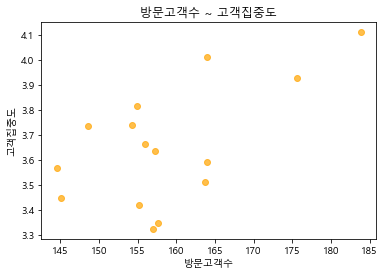

평균대기시간 & 고객집중도 상관관계 : 0.9856353346049168
평균대기시간 & 고객집중도 p-value : 1.999076901998454e-11


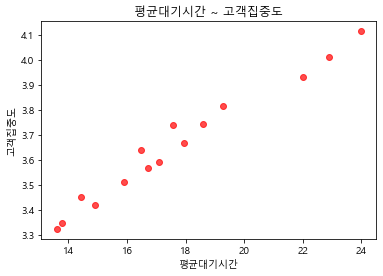

In [283]:
X = rev1.방문고객수.values
Y1 = rev1.평균대기시간.values
Y2 = rev1.고객집중도.values

print('{0} & {1} 상관관계 : {2}' .format('방문고객수','평균대기시간',np.corrcoef(X,Y1)[0,1]))
print('{0} & {1} p-value : {2}' .format('방문고객수','평균대기시간',stats.pearsonr(X,Y1)[1]))
plt.scatter(X, Y1, color = 'purple', alpha = 0.6)
plt.title('방문고객수 ~ 평균대기시간')
plt.xlabel('방문고객수')
plt.ylabel('평균대기시간')
plt.show()

print('{0} & {1} 상관관계 : {2}' .format('방문고객수','고객집중도',np.corrcoef(X,Y2)[0,1]))
print('{0} & {1} p-value : {2}' .format('방문고객수','고객집중도',stats.pearsonr(X,Y2)[1]))
plt.scatter(X, Y2, color = 'orange', alpha = 0.7)
plt.title('방문고객수 ~ 고객집중도')
plt.xlabel('방문고객수')
plt.ylabel('고객집중도')
plt.show()

print('{0} & {1} 상관관계 : {2}' .format('평균대기시간','고객집중도',np.corrcoef(Y1,Y2)[0,1]))
print('{0} & {1} p-value : {2}' .format('평균대기시간','고객집중도',stats.pearsonr(Y1,Y2)[1]))
plt.scatter(Y1, Y2, color = 'red', alpha = 0.7)
plt.title('평균대기시간 ~ 고객집중도')
plt.xlabel('평균대기시간')
plt.ylabel('고객집중도')
plt.show()

< 1 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : -0.4628559447122357
방문고객수 & 평균대기시간 p-value : 0.08231740161413388
방문고객수 & 고객집중도 상관관계 : -0.5074689355873642
방문고객수 & 고객집중도 p-value : 0.053484531668685754


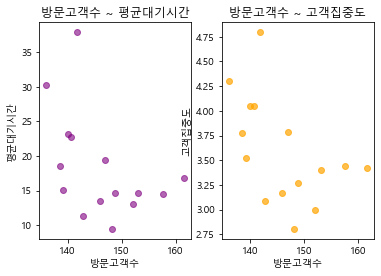

< 2 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : 0.17924200161998083
방문고객수 & 평균대기시간 p-value : 0.5227019836020174
방문고객수 & 고객집중도 상관관계 : 0.11913263919643349
방문고객수 & 고객집중도 p-value : 0.6723813267321972


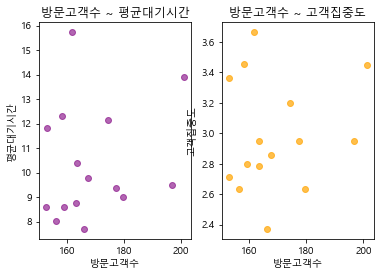

< 3 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : 0.1478565311335338
방문고객수 & 평균대기시간 p-value : 0.5989771940843052
방문고객수 & 고객집중도 상관관계 : 0.05005789998225917
방문고객수 & 고객집중도 p-value : 0.8593797822389475


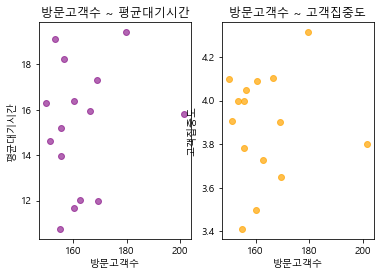

< 4 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : 0.5156019067347976
방문고객수 & 평균대기시간 p-value : 0.0491570114775792
방문고객수 & 고객집중도 상관관계 : 0.5239546918714573
방문고객수 & 고객집중도 p-value : 0.044986734640205465


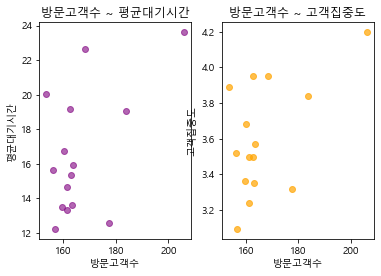

< 5 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : 0.5250165264462383
방문고객수 & 평균대기시간 p-value : 0.044475989578240394
방문고객수 & 고객집중도 상관관계 : 0.5183738283750645
방문고객수 & 고객집중도 p-value : 0.047742766572842814


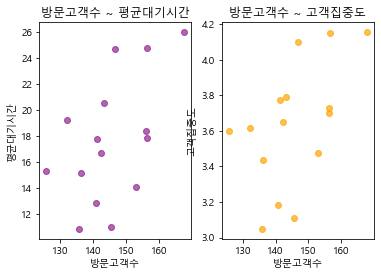

< 6 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : -0.3661731725404951
방문고객수 & 평균대기시간 p-value : 0.17948661363865323
방문고객수 & 고객집중도 상관관계 : -0.35376720058819583
방문고객수 & 고객집중도 p-value : 0.1958067435208156


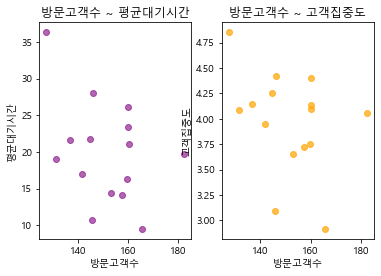

< 7 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : 0.058589016787618506
방문고객수 & 평균대기시간 p-value : 0.8356933027634366
방문고객수 & 고객집중도 상관관계 : 0.16849807303459122
방문고객수 & 고객집중도 p-value : 0.5483108479134485


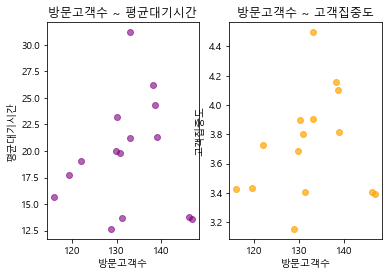

< 8 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : 0.015572945994916616
방문고객수 & 평균대기시간 p-value : 0.9560715576283007
방문고객수 & 고객집중도 상관관계 : 0.13805729314622894
방문고객수 & 고객집중도 p-value : 0.6236616403311874


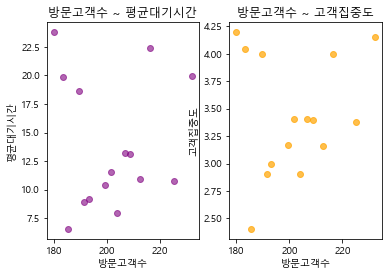

< 9 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : -0.3279855913561381
방문고객수 & 평균대기시간 p-value : 0.23269272871904573
방문고객수 & 고객집중도 상관관계 : -0.49206776636650934
방문고객수 & 고객집중도 p-value : 0.06243450655789152


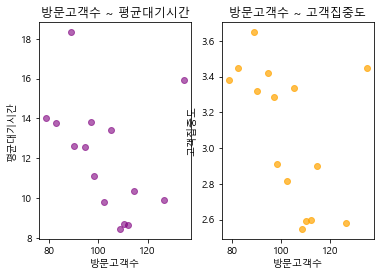

< 10 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : -0.45347835145897897
방문고객수 & 평균대기시간 p-value : 0.08955992400331697
방문고객수 & 고객집중도 상관관계 : -0.07105869596577036
방문고객수 & 고객집중도 p-value : 0.8013109941050592


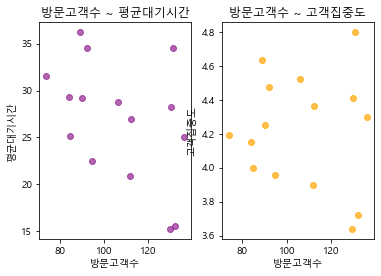

< 11 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : 0.049438892773681076
방문고객수 & 평균대기시간 p-value : 0.8611030184114113
방문고객수 & 고객집중도 상관관계 : -0.17456218495042966
방문고객수 & 고객집중도 p-value : 0.533789871508629


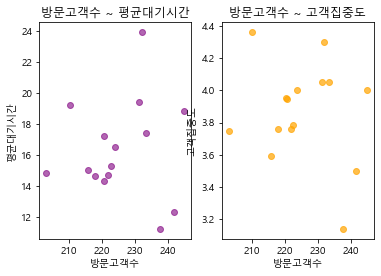

< 12 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : 0.4333334898841309
방문고객수 & 평균대기시간 p-value : 0.10661886649151056
방문고객수 & 고객집중도 상관관계 : 0.37599756983341237
방문고객수 & 고객집중도 p-value : 0.16721242413798146


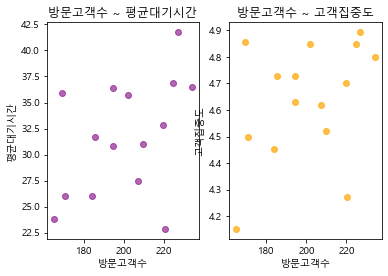

< 13 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : 0.45438618643345413
방문고객수 & 평균대기시간 p-value : 0.08883977216332031
방문고객수 & 고객집중도 상관관계 : 0.5823954794450404
방문고객수 & 고객집중도 p-value : 0.02272057106526084


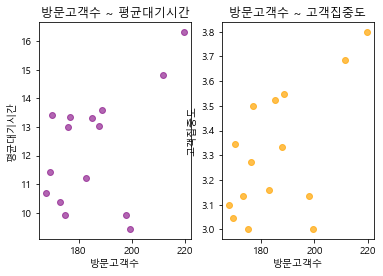

< 14 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : 0.21919438867116448
방문고객수 & 평균대기시간 p-value : 0.43250930113683156
방문고객수 & 고객집중도 상관관계 : 0.25729400568532845
방문고객수 & 고객집중도 p-value : 0.3545676336185403


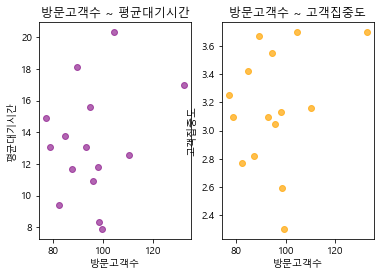

< 15 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : 0.02644525421439736
방문고객수 & 평균대기시간 p-value : 0.925465183518116
방문고객수 & 고객집중도 상관관계 : -0.06773998322020129
방문고객수 & 고객집중도 p-value : 0.8104311787238105


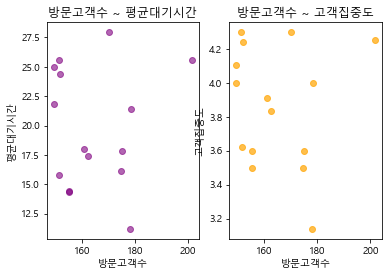

< 16 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : 0.6604130092139215
방문고객수 & 평균대기시간 p-value : 0.00736688682364355
방문고객수 & 고객집중도 상관관계 : 0.6323200245554788
방문고객수 & 고객집중도 p-value : 0.01142734815189887


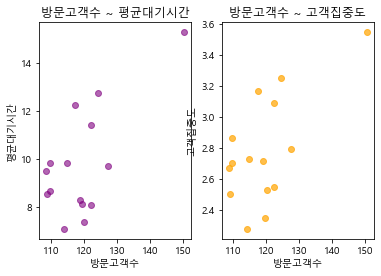

< 17 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : 0.2476282106156284
방문고객수 & 평균대기시간 p-value : 0.3735559831181507
방문고객수 & 고객집중도 상관관계 : 0.24660735596532715
방문고객수 & 고객집중도 p-value : 0.3755931271276803


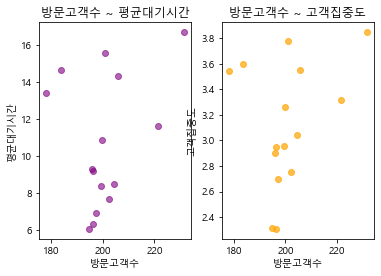

< 18 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : 0.5032705002488765
방문고객수 & 평균대기시간 p-value : 0.05582469798363888
방문고객수 & 고객집중도 상관관계 : 0.5239402799509587
방문고객수 & 고객집중도 p-value : 0.04499369652310862


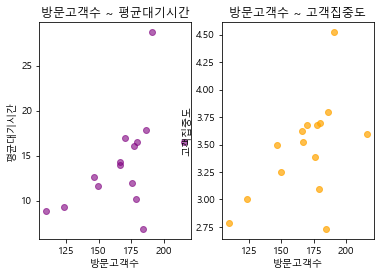

< 19 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : 0.3785777226476478
방문고객수 & 평균대기시간 p-value : 0.1640832406760432
방문고객수 & 고객집중도 상관관계 : 0.10711430563230749
방문고객수 & 고객집중도 p-value : 0.7039766196981295


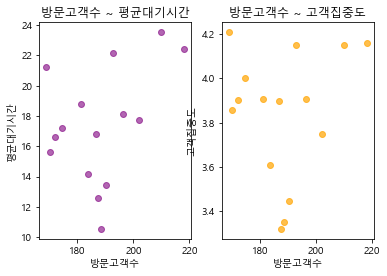

< 20 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : -0.3257333485390604
방문고객수 & 평균대기시간 p-value : 0.23610703184024223
방문고객수 & 고객집중도 상관관계 : -0.15531388751285177
방문고객수 & 고객집중도 p-value : 0.5804581840274272


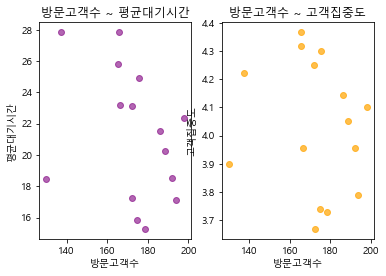

< 21 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : 0.2565966911604162
방문고객수 & 평균대기시간 p-value : 0.3559192427323117
방문고객수 & 고객집중도 상관관계 : 0.19707130716698001
방문고객수 & 고객집중도 p-value : 0.48143893902394747


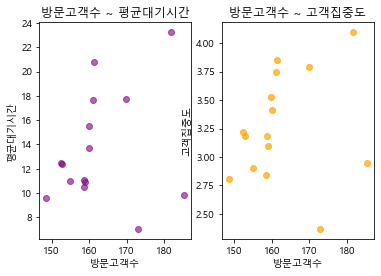

< 22 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : 0.7848723873822822
방문고객수 & 평균대기시간 p-value : 0.0005286274161821117
방문고객수 & 고객집중도 상관관계 : 0.7318341782064088
방문고객수 & 고객집중도 p-value : 0.00192575496120298


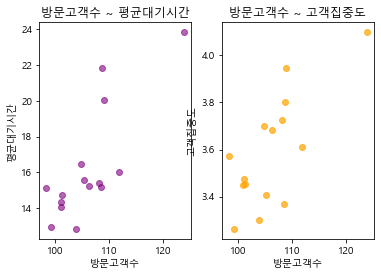

< 23 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : -0.5134528415228724
방문고객수 & 평균대기시간 p-value : 0.05027451989135925
방문고객수 & 고객집중도 상관관계 : -0.4904753365186487
방문고객수 & 고객집중도 p-value : 0.06341821141262703


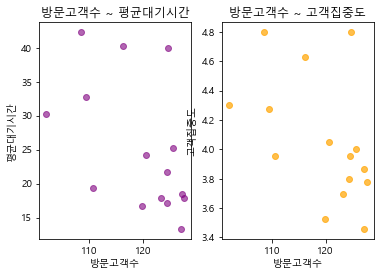

< 24 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : 0.4244283803797036
방문고객수 & 평균대기시간 p-value : 0.11483565494320538
방문고객수 & 고객집중도 상관관계 : 0.37068542617103534
방문고객수 & 고객집중도 p-value : 0.1737783055575267


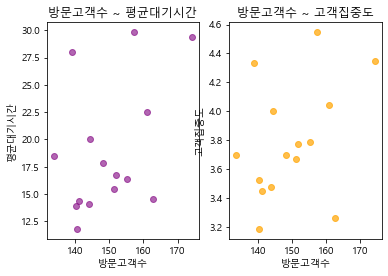

< 25 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : 0.23297557722284337
방문고객수 & 평균대기시간 p-value : 0.40336790141931667
방문고객수 & 고객집중도 상관관계 : 0.31194250086525854
방문고객수 & 고객집중도 p-value : 0.2576889587536506


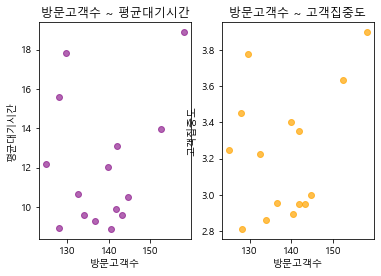

< 26 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : -0.07397598359137918
방문고객수 & 평균대기시간 p-value : 0.7933135466603932
방문고객수 & 고객집중도 상관관계 : -0.164734228663158
방문고객수 & 고객집중도 p-value : 0.5574089217220742


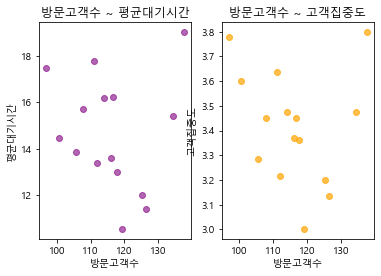

< 27 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : 0.3282984739358102
방문고객수 & 평균대기시간 p-value : 0.23222086080540116
방문고객수 & 고객집중도 상관관계 : 0.2139228255178335
방문고객수 & 고객집중도 p-value : 0.4439320808414361


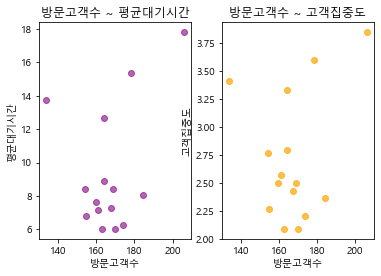

< 28 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : 0.022213596390420243
방문고객수 & 평균대기시간 p-value : 0.9373683032627199
방문고객수 & 고객집중도 상관관계 : -0.027959081556301085
방문고객수 & 고객집중도 p-value : 0.9212104157666616


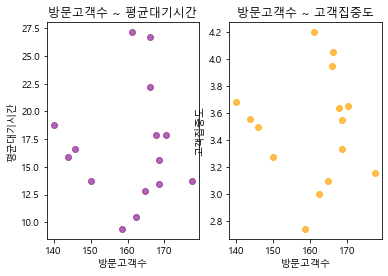

< 29 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : 0.602946416994847
방문고객수 & 평균대기시간 p-value : 0.01734661399548617
방문고객수 & 고객집중도 상관관계 : 0.6161737860534382
방문고객수 & 고객집중도 p-value : 0.014444472356583927


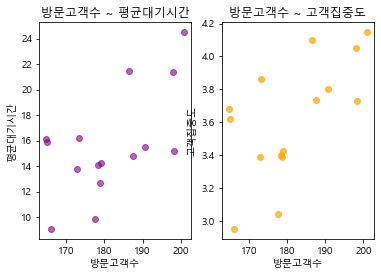

< 30 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : 0.24853334432063098
방문고객수 & 평균대기시간 p-value : 0.37175480311659764
방문고객수 & 고객집중도 상관관계 : 0.3521684043121933
방문고객수 & 고객집중도 p-value : 0.19797711881991192


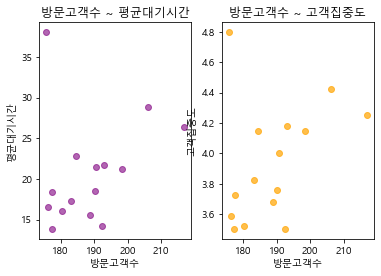

< 31 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : -0.22805201493567828
방문고객수 & 평균대기시간 p-value : 0.41365813662331696
방문고객수 & 고객집중도 상관관계 : -0.17932616827972833
방문고객수 & 고객집중도 p-value : 0.5225035248295155


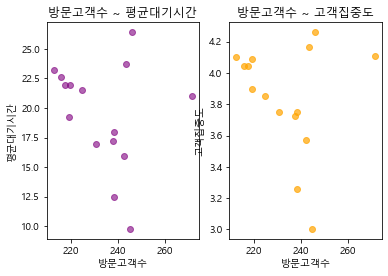

< 32 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : -0.17389237616241682
방문고객수 & 평균대기시간 p-value : 0.5353853417561473
방문고객수 & 고객집중도 상관관계 : -0.16266292992245562
방문고객수 & 고객집중도 p-value : 0.5624430994451917


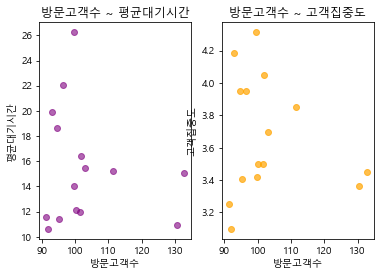

< 33 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : 0.07513749782622553
방문고객수 & 평균대기시간 p-value : 0.790134640549967
방문고객수 & 고객집중도 상관관계 : 0.2909642616088405
방문고객수 & 고객집중도 p-value : 0.29274472925473133


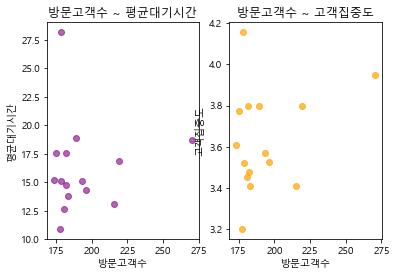

< 34 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : 0.3123786214236992
방문고객수 & 평균대기시간 p-value : 0.2569886622570806
방문고객수 & 고객집중도 상관관계 : 0.5777515940209865
방문고객수 & 고객집중도 p-value : 0.024093508175593987


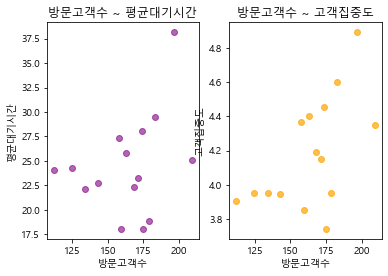

< 35 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : -0.24107688467014174
방문고객수 & 평균대기시간 p-value : 0.3867336360297349
방문고객수 & 고객집중도 상관관계 : -0.13110558311116705
방문고객수 & 고객집중도 p-value : 0.6414032050005322


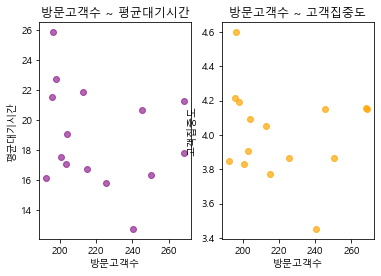

< 36 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : 0.07078461536095176
방문고객수 & 평균대기시간 p-value : 0.8020633123577972
방문고객수 & 고객집중도 상관관계 : 0.17806675185612428
방문고객수 & 고객집중도 p-value : 0.5254766858442557


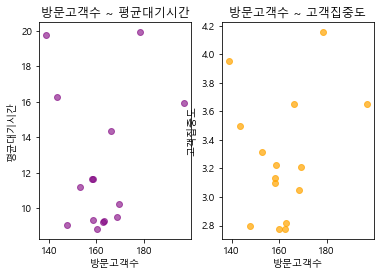

< 37 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : -0.4419308578598241
방문고객수 & 평균대기시간 p-value : 0.09908306260016359
방문고객수 & 고객집중도 상관관계 : -0.3863930940825021
방문고객수 & 고객집중도 p-value : 0.15484225625864922


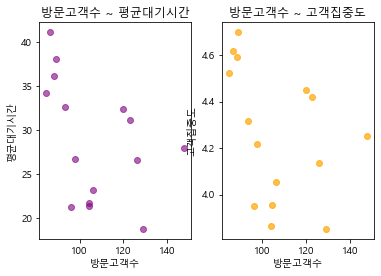

< 38 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : 0.3713243184864511
방문고객수 & 평균대기시간 p-value : 0.17297981397420972
방문고객수 & 고객집중도 상관관계 : 0.23792834705644142
방문고객수 & 고객집중도 p-value : 0.3931542193453618


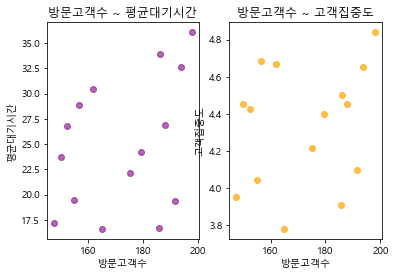

< 39 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : 0.29834066150551397
방문고객수 & 평균대기시간 p-value : 0.2801127675183783
방문고객수 & 고객집중도 상관관계 : 0.03834869140037121
방문고객수 & 고객집중도 p-value : 0.892068434510786


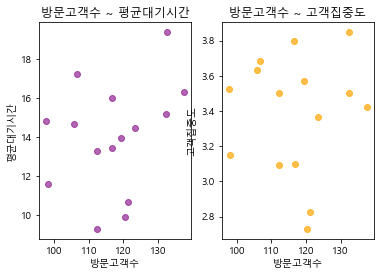

< 40 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : 0.17467896785295717
방문고객수 & 평균대기시간 p-value : 0.5335119134979414
방문고객수 & 고객집중도 상관관계 : 0.15428070957106532
방문고객수 & 고객집중도 p-value : 0.5830097661587565


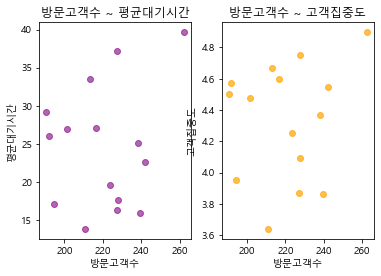

< 41 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : -0.009895766915257894
방문고객수 & 평균대기시간 p-value : 0.9720784456636303
방문고객수 & 고객집중도 상관관계 : 0.16399481386660214
방문고객수 & 고객집중도 p-value : 0.5592038133930872


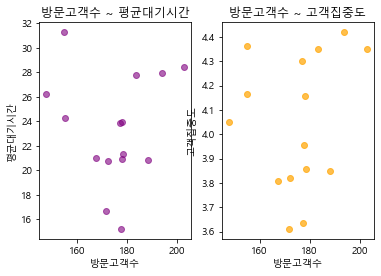

< 42 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : 0.40479023271766673
방문고객수 & 평균대기시간 p-value : 0.13447838587369376
방문고객수 & 고객집중도 상관관계 : 0.38767290657993025
방문고객수 & 고객집중도 p-value : 0.15336282069329313


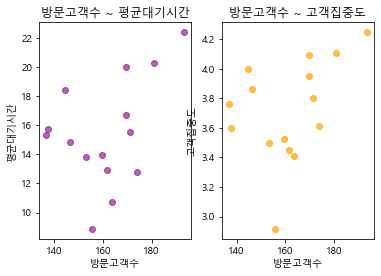

< 43 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : 0.5569242262164841
방문고객수 & 평균대기시간 p-value : 0.03104106248261425
방문고객수 & 고객집중도 상관관계 : 0.38831529082316196
방문고객수 & 고객집중도 p-value : 0.15262380986931443


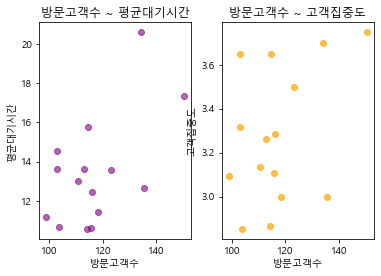

< 44 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : -0.5192469532704603
방문고객수 & 평균대기시간 p-value : 0.04730357514672703
방문고객수 & 고객집중도 상관관계 : -0.4736719044378853
방문고객수 & 고객집중도 p-value : 0.07449337861790611


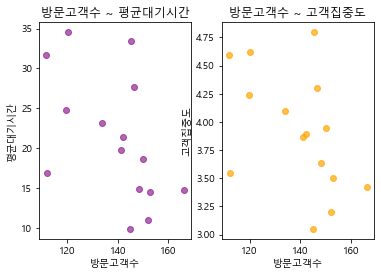

< 45 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : -0.12843734543885163
방문고객수 & 평균대기시간 p-value : 0.6482616073475986
방문고객수 & 고객집중도 상관관계 : -0.002910513633193243
방문고객수 & 고객집중도 p-value : 0.9917864483420551


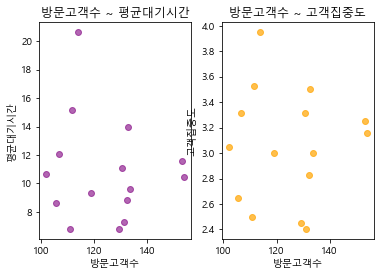

< 46 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : 0.6393964588850449
방문고객수 & 평균대기시간 p-value : 0.01027108446406408
방문고객수 & 고객집중도 상관관계 : 0.5206412176200773
방문고객수 & 고객집중도 p-value : 0.046608436615880884


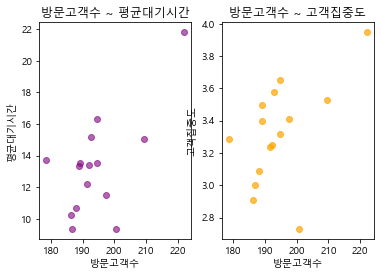

< 47 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : 0.2746791913167735
방문고객수 & 평균대기시간 p-value : 0.32179894296446404
방문고객수 & 고객집중도 상관관계 : 0.241402473469714
방문고객수 & 고객집중도 p-value : 0.3860729136964792


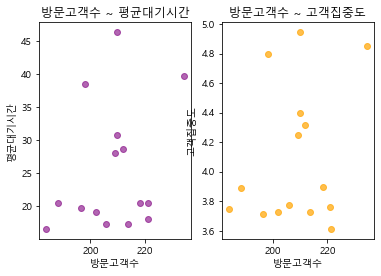

< 48 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : -0.31427658735699293
방문고객수 & 평균대기시간 p-value : 0.2539545535575293
방문고객수 & 고객집중도 상관관계 : -0.22189775432470693
방문고객수 & 고객집중도 p-value : 0.4267101087430756


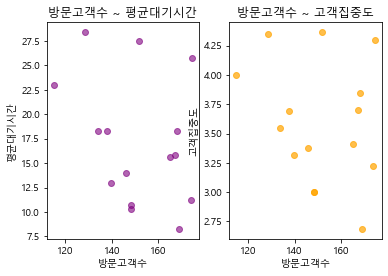

< 49 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : -0.22042543420130356
방문고객수 & 평균대기시간 p-value : 0.4298635361206286
방문고객수 & 고객집중도 상관관계 : -0.22561011975158538
방문고객수 & 고객집중도 p-value : 0.41881184521596426


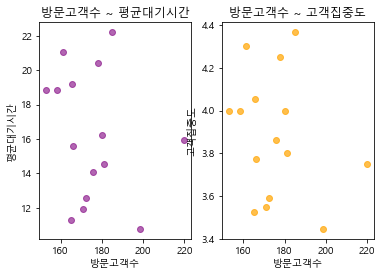

< 50 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : 0.21892196082630777
방문고객수 & 평균대기시간 p-value : 0.43309592093269567
방문고객수 & 고객집중도 상관관계 : 0.41110128104744154
방문고객수 & 고객집중도 p-value : 0.12793371214300434


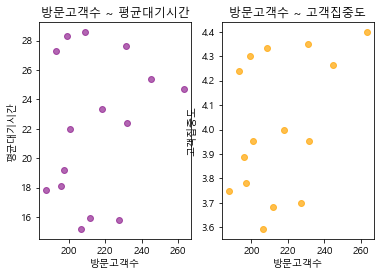

< 51 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : -0.28696519430338685
방문고객수 & 평균대기시간 p-value : 0.29973112477717867
방문고객수 & 고객집중도 상관관계 : -0.04619264919974362
방문고객수 & 고객집중도 p-value : 0.8701494994090119


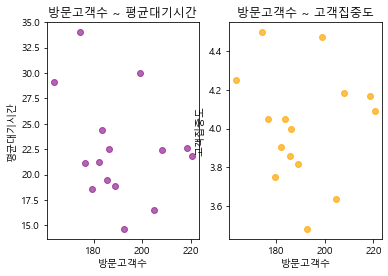

< 52 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : 0.7518417303651577
방문고객수 & 평균대기시간 p-value : 0.0012267442837393878
방문고객수 & 고객집중도 상관관계 : 0.7097423209799676
방문고객수 & 고객집중도 p-value : 0.003036714976370038


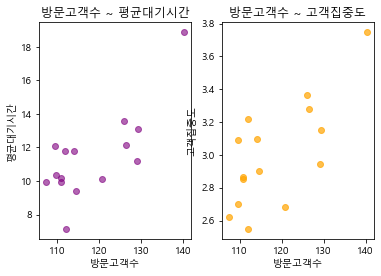

< 53 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : 0.43061382587359964
방문고객수 & 평균대기시간 p-value : 0.10908351255400396
방문고객수 & 고객집중도 상관관계 : 0.20529749838836686
방문고객수 & 고객집중도 p-value : 0.46294338248770567


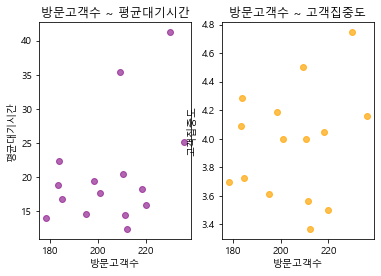

< 54 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : -0.6224221058107098
방문고객수 & 평균대기시간 p-value : 0.013211636555685037
방문고객수 & 고객집중도 상관관계 : -0.6527584377556788
방문고객수 & 고객집중도 p-value : 0.008338035476651866


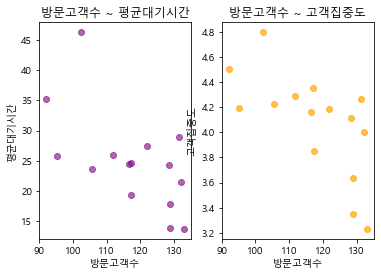

< 55 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : -0.1848717317966772
방문고객수 & 평균대기시간 p-value : 0.5095030357241268
방문고객수 & 고객집중도 상관관계 : -0.2666672741802961
방문고객수 & 고객집중도 p-value : 0.3366774296456395


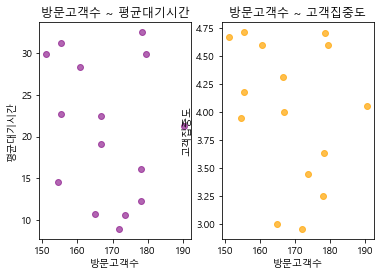

< 56 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : -0.4036930837879138
방문고객수 & 평균대기시간 p-value : 0.13563889835691575
방문고객수 & 고객집중도 상관관계 : -0.3060641581008023
방문고객수 & 고객집중도 p-value : 0.2672414029405389


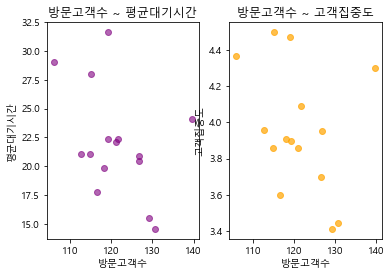

< 57 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : 0.04407115529453168
방문고객수 & 평균대기시간 p-value : 0.876069730958168
방문고객수 & 고객집중도 상관관계 : -0.16268912062727897
방문고객수 & 고객집중도 p-value : 0.5623793241282603


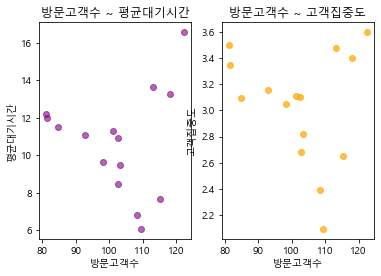

< 58 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : -0.1976268359557933
방문고객수 & 평균대기시간 p-value : 0.4801788946283611
방문고객수 & 고객집중도 상관관계 : -0.11200185902034568
방문고객수 & 고객집중도 p-value : 0.691070035047133


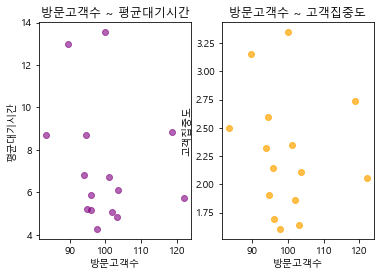

< 59 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : -0.5511573554692402
방문고객수 & 평균대기시간 p-value : 0.03320728651461856
방문고객수 & 고객집중도 상관관계 : -0.384552989169565
방문고객수 & 고객집중도 p-value : 0.15698601417999666


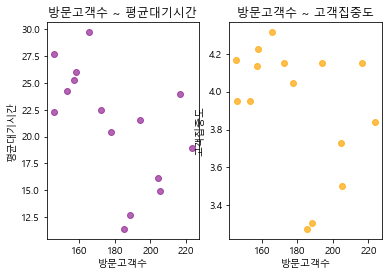

< 60 번 센터코드 지표 >
방문고객수 & 평균대기시간 상관관계 : -0.2809612222173243
방문고객수 & 평균대기시간 p-value : 0.31040172047987374
방문고객수 & 고객집중도 상관관계 : -0.220787032380738
방문고객수 & 고객집중도 p-value : 0.4290879623127603


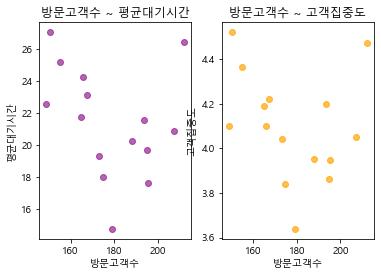

In [292]:
cen_corr = []
cen_py = []

for i in range(60):
    rev_tmp = rev2[i*15:(i+1)*15]
    X = rev_tmp.방문고객수.values
    Y1 = rev_tmp.평균대기시간.values
    Y2 = rev_tmp.고객집중도.values
    print('< {0} 번 센터코드 지표 >' .format(i+1))
    print('{0} & {1} 상관관계 : {2}' .format('방문고객수','평균대기시간',np.corrcoef(X,Y1)[0,1]))
    print('{0} & {1} p-value : {2}' .format('방문고객수','평균대기시간',stats.pearsonr(X,Y1)[1]))
    print('{0} & {1} 상관관계 : {2}' .format('방문고객수','고객집중도',np.corrcoef(X,Y2)[0,1]))
    print('{0} & {1} p-value : {2}' .format('방문고객수','고객집중도',stats.pearsonr(X,Y2)[1]))
    
    cen_corr.append(stats.pearsonr(X,Y1)[0])
    cen_py.append(stats.pearsonr(X,Y1)[1])
    
    plt.subplot(121)
    plt.scatter(X, Y1, color = 'purple', alpha = 0.6)
    plt.title('방문고객수 ~ 평균대기시간')
    plt.xlabel('방문고객수')
    plt.ylabel('평균대기시간')
    plt.subplot(122)
    plt.scatter(X, Y2, color = 'orange', alpha = 0.7)
    plt.title('방문고객수 ~ 고객집중도')
    plt.xlabel('방문고객수')
    plt.ylabel('고객집중도')
    plt.show()

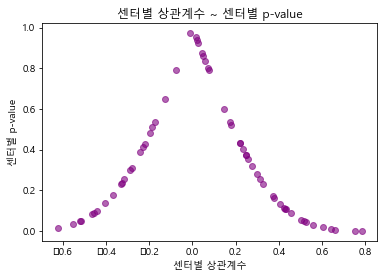

[3, 4, 11, 12, 13, 15, 16, 17, 18, 20, 21, 23, 24, 26, 28, 29, 33, 37, 38, 41, 42, 45, 46, 49, 51, 52]
[0, 5, 8, 9, 19, 22, 30, 34, 36, 43, 47, 48, 50, 53, 55, 58, 59]
[1, 2, 6, 7, 10, 14, 25, 27, 31, 32, 35, 39, 40, 44, 54, 56, 57]


In [306]:
#print(cen_corr)
#print(cen_py)
plt.scatter(cen_corr, cen_py, color = 'purple', alpha = 0.6)
plt.title('센터별 상관계수 ~ 센터별 p-value')
plt.xlabel('센터별 상관계수')
plt.ylabel('센터별 p-value')
plt.show()

cen_corr_stp = []
cen_corr_stm = []
cen_corr_we = []

for i in cen_corr:
    if abs(i) >= 0.2 and cen_py[cen_corr.index(i)] < 0.5:
        if i > 0:
            cen_corr_stp.append(cen_corr.index(i))
        else:
            cen_corr_stm.append(cen_corr.index(i))
    else:
        cen_corr_we.append(cen_corr.index(i))
print(cen_corr_stp)
print(cen_corr_stm)
print(cen_corr_we)

평균대기시간 & 고객비율_20대미만 상관관계 : 0.0662335937018027
평균대기시간 & 고객비율_20대미만 p-value : 0.8145784509596908


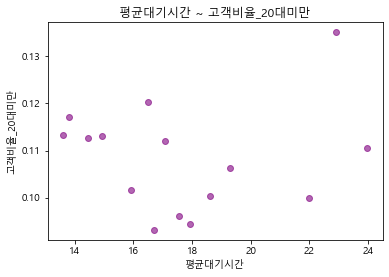

평균대기시간 & 고객비율_20대30대 상관관계 : 0.3957021346668596
평균대기시간 & 고객비율_20대30대 p-value : 0.14429656458721385


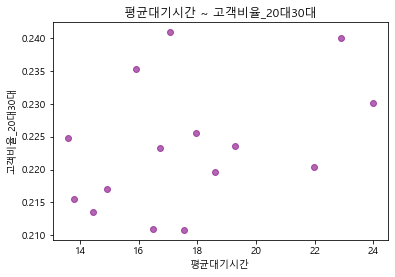

평균대기시간 & 고객비율_40대50대 상관관계 : -0.1890823339698518
평균대기시간 & 고객비율_40대50대 p-value : 0.49973273210255675


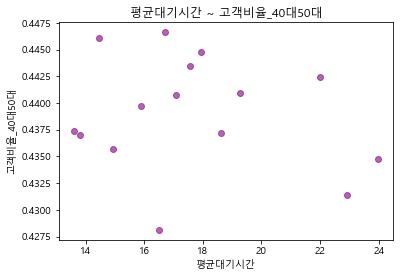

평균대기시간 & 고객비율_60대이상 상관관계 : -0.25252972321170364
평균대기시간 & 고객비율_60대이상 p-value : 0.3638589788186106


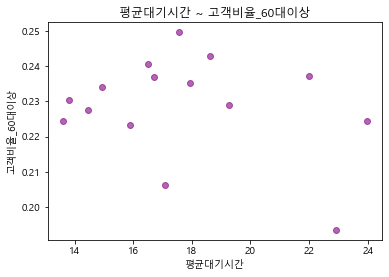

In [336]:
rev1_1 = rev1[['평균대기시간','고객집중도']]
rev3 = df[1].groupby(by='년월').mean()
rev4 = pd.merge(rev1_1, rev3, on='년월')

X_1 = rev4.평균대기시간.values
Y1_1 = rev4.고객비율_20대미만.values
Y2_1 = rev3.고객비율_20대30대.values
Y3_1 = rev3.고객비율_40대50대.values
Y4_1 = rev3.고객비율_60대이상.values

print('{0} & {1} 상관관계 : {2}' .format('평균대기시간','고객비율_20대미만',np.corrcoef(X_1,Y1_1)[0,1]))
print('{0} & {1} p-value : {2}' .format('평균대기시간','고객비율_20대미만',stats.pearsonr(X_1,Y1_1)[1]))
plt.scatter(X_1, Y1_1, color = 'purple', alpha = 0.6)
plt.title('평균대기시간 ~ 고객비율_20대미만')
plt.xlabel('평균대기시간')
plt.ylabel('고객비율_20대미만')
plt.show()

print('{0} & {1} 상관관계 : {2}' .format('평균대기시간','고객비율_20대30대',np.corrcoef(X_1,Y2_1)[0,1]))
print('{0} & {1} p-value : {2}' .format('평균대기시간','고객비율_20대30대',stats.pearsonr(X_1,Y2_1)[1]))
plt.scatter(X_1, Y2_1, color = 'purple', alpha = 0.6)
plt.title('평균대기시간 ~ 고객비율_20대30대')
plt.xlabel('평균대기시간')
plt.ylabel('고객비율_20대30대')
plt.show()

print('{0} & {1} 상관관계 : {2}' .format('평균대기시간','고객비율_40대50대',np.corrcoef(X_1,Y3_1)[0,1]))
print('{0} & {1} p-value : {2}' .format('평균대기시간','고객비율_40대50대',stats.pearsonr(X_1,Y3_1)[1]))
plt.scatter(X_1, Y3_1, color = 'purple', alpha = 0.6)
plt.title('평균대기시간 ~ 고객비율_40대50대')
plt.xlabel('평균대기시간')
plt.ylabel('고객비율_40대50대')
plt.show()

print('{0} & {1} 상관관계 : {2}' .format('평균대기시간','고객비율_60대이상',np.corrcoef(X_1,Y4_1)[0,1]))
print('{0} & {1} p-value : {2}' .format('평균대기시간','고객비율_60대이상',stats.pearsonr(X_1,Y4_1)[1]))
plt.scatter(X_1, Y4_1, color = 'purple', alpha = 0.6)
plt.title('평균대기시간 ~ 고객비율_60대이상')
plt.xlabel('평균대기시간')
plt.ylabel('고객비율_60대이상')
plt.show()


# rev4 = df[0].groupby(by=['센터코드','년월']).mean()
# rev5 = pd.merge(df[1], rev3, on='년월')

#rev6 = pd.merge(df[1], rev3, on=['센터코드','년월'])
#rev6

In [ ]:
X_1 = rev3.방문고객수.values
Y1_1 = rev3..values
Y2_1 = rev3.고객집중도.values

print('{0} & {1} 상관관계 : {2}' .format('방문고객수','평균대기시간',np.corrcoef(X,Y1)[0,1]))
print('{0} & {1} p-value : {2}' .format('방문고객수','평균대기시간',stats.pearsonr(X,Y1)[1]))
plt.scatter(X, Y1, color = 'purple', alpha = 0.6)
plt.title('방문고객수 ~ 평균대기시간')
plt.xlabel('방문고객수')
plt.ylabel('평균대기시간')
plt.show()


In [330]:
rev1_1 = rev1[['평균대기시간','고객집중도']]
rev1_1

평균대기시간     고객집중도
년월                             
2020-01-01  23.984158  4.113333
2020-02-01  22.911067  4.010833
2020-03-01  17.079689  3.592424
2020-04-01  15.904708  3.512500
2020-05-01  21.989833  3.929825
2020-06-01  13.596841  3.323485
2020-07-01  14.923862  3.420290
2020-08-01  19.281908  3.815000
2020-09-01  18.604897  3.741270
2020-10-01  17.943982  3.665789
2020-11-01  16.721159  3.568254
2020-12-01  17.562652  3.738636
2021-01-01  14.446225  3.450000
2021-02-01  16.491704  3.638889
2021-03-01  13.795326  3.349242

In [12]:
# 서울시 행정구역 좌표 
# 출처 : https://github.com/cubensys/Korea_District/blob/master/3_%EC%84%9C%EC%9A%B8%EC%8B%9C_%EC%9E%90%EC%B9%98%EA%B5%AC/%EC%84%9C%EC%9A%B8%EC%8B%9C_%EC%9E%90%EC%B9%98%EA%B5%AC_%EC%A4%91%EC%8B%AC%EC%A0%90_2017.csv

cen_loc = pd.read_csv('./서울시_자치구_중심점_2017.csv')
cen_loc = cen_loc.drop(['코드', '시도명'], axis=1)
cen_loc

gu = cen_loc['시군구명'].tolist()
x = cen_loc['X'].tolist()
y = cen_loc['Y'].tolist()
xy = [tuple([i,j]) for i,j in zip(x,y)]

cen_loc_dic = {k:v for k,v in zip(gu, xy)}
print(cen_loc_dic)

{'종로구': (126.9773213, 37.59491732), '중구': (126.9959681, 37.56014356), '용산구': (126.979907, 37.53138497), '성동구': (127.0410585, 37.55102969), '광진구': (127.0857435, 37.54670608), '동대문구': (127.0548481, 37.58195655), '중랑구': (127.0928803, 37.59780259), '성북구': (127.0175795, 37.6057019), '강북구': (127.011189, 37.64347391), '도봉구': (127.0323688, 37.66910208), '노원구': (127.0750347, 37.65251105), '은평구': (126.9270229, 37.61921128), '서대문구': (126.9390631, 37.57778531), '마포구': (126.90827, 37.55931349), '양천구': (126.8554777, 37.52478941), '강서구': (126.822807, 37.56123543), '구로구': (126.8563006, 37.49440543), '금천구': (126.9008202, 37.46056756), '영등포구': (126.9101695, 37.52230829), '동작구': (126.9516415, 37.49887688), '관악구': (126.9453372, 37.46737569), '서초구': (127.0312203, 37.47329547), '강남구': (127.0629852, 37.49664389), '송파구': (127.115295, 37.50561924), '강동구': (127.1470118, 37.55045024)}


In [13]:
# 행정구별 센터 합계 구해서 시각화하기

loc_dic = {}
loc_list = df[2]['시군구'].to_list()

for i in loc_list:
    if i in loc_dic:
        loc_dic[i] += 1
    else:
        loc_dic[i] = 1
        
col1 = list(loc_dic.keys())
col2 = list(loc_dic.values())
no_cen = []

for i in gu:
    if i not in col1:
        no_cen.append(i)

col1 = col1 + no_cen
col2 = col2 + [0 for i in range(len(no_cen))]

loc_tmp = pd.DataFrame(zip(col1,col2), columns = ['name', '센터 합계'])
loc_tmp

name  센터 합계
0    마포구      2
1    성동구      1
2   동대문구      2
3    동작구      2
4   영등포구      2
5    성북구      6
6    구로구      2
7    종로구      1
8    광진구      5
9    중랑구      3
10   강남구      2
11   송파구      6
12   관악구      5
13   강북구      1
14   양천구      4
15   노원구      3
16  서대문구      3
17   용산구      1
18   은평구      4
19   강서구      1
20   도봉구      2
21   서초구      1
22   강동구      1
23    중구      0
24   금천구      0

In [ ]:
# 행정동별 센터 합계 구해서 시각화하기

df[2] = df[2][['센터코드']]

In [34]:
k = pd.DataFrame([['조원동',10],['송천동',100]], columns = ['name', '센터 합계'])
k

name  센터 합계
0  조원동     10
1  송천동    100

In [28]:
# 파라미터 선언
geo_json1 = 'https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo.json'
geo_json2 = 'https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_submunicipalities_geo.json'
# 출처 : https://github.com/southkorea/seoul-maps/blob/master/kostat/2013/json/seoul_municipalities_geo.json


# 행정구별 센터 개수 시각화
m1 = folium.Map(
    location = [37.541, 126.986],
    zoom_start = 10.5,
    tiles = 'CartoDB positron'
)

folium.Choropleth(
    geo_data = geo_json1,
    name = 'choropleth',
    data = loc_tmp,
    columns = ['name', '센터 합계'],
    key_on = 'feature.properties.name',
    fill_color = 'PuBu',
    fill_opacity = 0.7,
    line_opacity = 0.7
).add_to(m1)

# show
m1
#m1.save('my_map.html')

In [185]:
# 센터유형별 서울시 지도 시각화

center_type = df[2][['행정동', '센터유형']]
center_type.columns = ['name', '센터유형']
center_type = center_type.replace({'센터유형' : 'G'}, 1)
center_type = center_type.replace({'센터유형' : 'S'}, 5)
center_type.columns

m2 = folium.Map(
    location = [37.541, 126.986],
    zoom_start = 10.5,
    tiles = 'CartoDB positron'
)

folium.Choropleth(
    geo_data = geo_json2,
    name = 'choropleth',
    data = center_type,
    columns = ['name', '센터유형'],
    key_on = 'feature.properties.name',
    fill_color = 'YlOrRd',
    fill_opacity = 0.7,
    line_opacity = 0.7
).add_to(m2)

# show
m2
# 노란색 -> G
# 빨간색 -> S

In [58]:
df_cus = df[1][['센터코드', '년월', '방문고객수']]
centercode = df_cus['센터코드'].to_list()
df_cus

센터코드      년월  방문고객수
0    0001  202001   2835
1    0001  202002   2720
2    0001  202003   3273
3    0001  202004   3062
4    0001  202005   3071
..    ...     ...    ...
895  0060  202011   3157
896  0060  202012   3411
897  0060  202101   2974
898  0060  202102   3012
899  0060  202103   3940

[900 rows x 3 columns]

In [ ]:
X = df.bmi.values
Y = df.index.values

import matplotlib.pyplot as plt
plt.scatter(X, Y, alpha=0.5)
plt.title('TARGET ~ BMI')
plt.xlabel('BMI')
plt.ylabel('TARGET')
plt.show()